In [1]:
'''
This is the best result we got from "multiple_experiments" notebook. However, RFE gave a better result in terms of MAE.
'''

'\nThis is the best result we got from "multiple_experiments" notebook. However, RFE gave a better result in terms of MAE.\n'

In [2]:
%load_ext autoreload
%autoreload 2

random_seed = 42
import numpy as np; np.random.seed(random_seed)

import sys
sys.path.insert(0, "../src/")
import pandas as pd

extracted_features_dir = "../data/extracted_features/"
labels_dir = "../data/labels/"
lang = "eng"

In [3]:
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.feature_selection import RFE
import xgboost
from copy import deepcopy
from utils import read_labels, read_extreme_cases
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.pyplot as plt
from collections import Counter
import random

labels = read_labels(labels_dir)
# canonization scores ground truths (extreme cases based on which canonoization scores were built)
extreme_cases_df = read_extreme_cases(labels_dir)

In [4]:
from sklearn.metrics import r2_score

global_list = []

class HyperParameterOptimizer(object):
    def __init__(self, book_names=None):
        self.book_names = book_names
        # self.model = None
        # self.feature_importances_ = None
    
    def fit(self, _train_X, _train_y):
        global global_list
        n_fold = 5
        df = np.hstack((self.book_names, _train_X))
        df = pd.DataFrame(df, columns=["book_name"] + [f"col_{i}" for i in range(_train_X.shape[1])])
        
        print(f"Current shape of feature matrix:", _train_X.shape)
        num_boost_round = 99999

        def feval(preds, train_data):
            labels = train_data.get_label()
            return 'r2', r2_score(labels, preds)
        
        all_results = []
        for max_depth in [4]:
            for learning_rate in [0.03]:
                for colsample_bytree in [0.33]:
                    for min_child_weight in [6]:
                        train_X = deepcopy(_train_X)
                        train_y = deepcopy(_train_y)
                        dtrain = xgboost.DMatrix(train_X, label=train_y)
                        params = {"max_depth": max_depth, "learning_rate": learning_rate, "colsample_bytree": colsample_bytree, "min_child_weight": min_child_weight, "n_jobs": -1}
                        cv_results = xgboost.cv(
                            params,
                            dtrain,
                            num_boost_round=num_boost_round,
                            seed=random_seed,
                            nfold=n_fold,
                            folds=_split_booknames(df, n_fold, return_indices=True),
                            feval=feval,
                            maximize=True,
                            early_stopping_rounds=5,
                            verbose_eval=False
                        )
                        print(train_X.shape[1], max_depth, learning_rate, colsample_bytree, min_child_weight, np.round(float(cv_results["test-r2-mean"].iloc[len(cv_results["test-r2-mean"])-1]), 4))
                        all_results.append((max_depth, learning_rate, colsample_bytree, min_child_weight, cv_results))
        all_results_df = pd.DataFrame(all_results, columns=["max_depth", "learning_rate", "colsample_bytree", "min_child_weight", "cv_results"])
        all_results_df["best_validation_r2"] = all_results_df["cv_results"].apply(lambda x: x.iloc[len(x)-1]["test-r2-mean"])
        all_results_df = all_results_df.sort_values(by="best_validation_r2", ascending=False).reset_index(drop=True)
        best_parameters = all_results_df.iloc[0]
        best_max_depth = int(best_parameters["max_depth"])
        best_learning_rate = float(best_parameters["learning_rate"])
        best_colsample_bytree = float(best_parameters["colsample_bytree"])
        best_min_child_weight = float(best_parameters["min_child_weight"])
        best_validation_r2 = float(best_parameters["best_validation_r2"])
        best_num_boost_round = int(len(best_parameters["cv_results"]))
        
        print("Current best max_depth:", best_max_depth)
        print("Current best learning_rate:", best_learning_rate)
        print("Current best colsample_bytree:", best_colsample_bytree)
        print("Current best min_child_weight:", best_min_child_weight)
        print("Current best num_boost_round:", best_num_boost_round)
        print(f"Current best validation r2 score is {np.round(best_validation_r2, 4)}")
        print("############################")
        params = {"max_depth": best_max_depth, "learning_rate": best_learning_rate, "colsample_bytree": best_colsample_bytree, "min_child_weight": best_min_child_weight, "n_jobs": -1}
        
        train_X = deepcopy(_train_X)
        train_y = deepcopy(_train_y)
        dtrain = xgboost.DMatrix(train_X, label=train_y)
        model = xgboost.train(params,
                              dtrain,
                              num_boost_round=best_num_boost_round,
                              verbose_eval=False)
        feature_importances = model.get_score(importance_type='gain')
        feature_importances_list = []
        for i in range(train_X.shape[1]):
            current_key = f'f{i}'
            if current_key in feature_importances:
                feature_importances_list.append(feature_importances[current_key])
            else:
                feature_importances_list.append(0.0)
        self.model = model
        self.feature_importances_ = np.array(feature_importances_list)
        
        global_list.append((best_validation_r2, train_X.shape[1], best_num_boost_round, params))
        
        return self
    
    def predict(self, X):
        return self.model.predict(xgboost.DMatrix(X))

    def predict_proba(self, X):
        return self.predict(X)
    
    def decision_function(self, X):
        return self.predict(X)
    
    def transform(self, X):
        return self.predict(X)

    def score(self, X=None, y=None):
        return 0.0

    def get_params(self, deep=True):
        return {'book_names': self.book_names}

    def set_params(self, **params):
        self.book_names = params['book_names']
        return self

    def _get_tags(self):
        return {"allow_nan": True}


def _split_booknames(df, nr_splits, return_indices=False):
    '''
    Distribute book names over splits.
    All works of an author are in the same split.
    '''
    book_names = df['book_name'].unique()
    authors = []
    booknames_authors_mapping = {}

    #Get authors
    for book_name in book_names:
        author = '_'.join(book_name.split('_')[:2])
        authors.append(author)
        if author in booknames_authors_mapping:
            booknames_authors_mapping[author].append(book_name)
        else:
            booknames_authors_mapping[author] = []
            booknames_authors_mapping[author].append(book_name)
    #Distribute authors over splits so that each split has approximately the same number of books
    works_per_author = Counter(authors)
    goal_sum = round(len(book_names)/nr_splits)
    tolerance = 0.03
    lower_threshold = goal_sum - round(tolerance*goal_sum)
    upper_threshold = goal_sum + round(tolerance*goal_sum)
    author_splits = []
    for i in range (0, nr_splits-1):
        works_in_split = 0
        split = []
        while works_in_split < upper_threshold:
            curr_author = random.choice(list(works_per_author.keys()))
            curr_author_workcount = works_per_author.pop(curr_author)
            #Reinsert into dict if value is too high
            if works_in_split + curr_author_workcount > upper_threshold:
                works_per_author[curr_author] = curr_author_workcount
            else:
                split.append(curr_author)
                works_in_split += curr_author_workcount
                if works_in_split >= lower_threshold:
                    break
        author_splits.append(split)
    #Create last split directly from remaining dict
    works_in_last_split = sum(works_per_author.values())
    split = list(works_per_author.keys())
    author_splits.append(split)

    if not return_indices:
        #Map author splits to book names
        book_splits = []
        for author_split in author_splits:
            book_split = []
            for author in author_split:
                book_split.extend(booknames_authors_mapping[author])
            book_splits.append(book_split)
    else:
        book_name_idx_mapping = dict((book_name, index) for index, book_name in enumerate(book_names))
        book_splits = []
        for author_split in author_splits:
            test_split = []
            for author in author_split:
                test_split.extend([book_name_idx_mapping[book_name] for book_name in booknames_authors_mapping[author]])
            train_split = list(set(book_name_idx_mapping.values()) - set(test_split))
            book_splits.append((train_split, test_split))
    return book_splits

In [5]:
class Experiment(object):
    def __init__(self, features, drop_columns_including, dimensionality_reduction, include_data, model, verbose):
        assert features in ["book", "chunk", "book_and_averaged_chunk", "chunk_and_copied_book"]
        assert isinstance(drop_columns_including, list)
        for i in drop_columns_including:
            assert isinstance(i, str)
        assert model in ["xgboost", "svr", "lasso"]
        assert (dimensionality_reduction in ["ss_pca_0_95", "k_best_f_reg_0_10", "k_best_mutual_info_0_10", "rfe"]) or (dimensionality_reduction is None)
        self.features = features
        self.labels = labels
        self.drop_columns_including = drop_columns_including
        self.include_data = include_data
        self.dimensionality_reduction = dimensionality_reduction
        self.model = model
        self.verbose = verbose

        if self.include_data != "train_reduced_test_reduced":
            if self.features == "book":
                self.df = deepcopy(book_df)
            elif self.features == "chunk":
                self.df = deepcopy(chunk_df)
            elif self.features == "chunk_and_copied_book":
                self.df = deepcopy(chunk_and_copied_book_df)
            elif self.features == "book_and_averaged_chunk":
                self.df = deepcopy(book_and_averaged_chunk_df)
        else:
            if self.features == "book":
                curr_book_df = deepcopy(book_df)
                self.df = curr_book_df.merge(extreme_cases_df, how='inner', left_on='book_name', right_on="file_name", validate="one_to_one").drop(columns=["file_name"])
            elif features == "chunk":
                curr_chunk_df = deepcopy(chunk_df)
                self.df = curr_chunk_df.merge(extreme_cases_df, how='inner', left_on='book_name', right_on="file_name", validate="many_to_one").drop(columns=["file_name"])
            elif features == "chunk_and_copied_book":
                curr_chunk_and_copied_book_df = deepcopy(chunk_and_copied_book_df)
                self.df = curr_chunk_and_copied_book_df.merge(extreme_cases_df, how='inner', left_on='book_name', right_on="file_name", validate="many_to_one").drop(columns=["file_name"])
            elif features == "book_and_averaged_chunk":
                curr_book_and_averaged_chunk_df = deepcopy(book_and_averaged_chunk_df)
                self.df = curr_book_and_averaged_chunk_df.merge(extreme_cases_df, how='inner', left_on='book_name', right_on="file_name", validate="one_to_one").drop(columns=["file_name"])

        columns_before_drop = set(self.df.columns)
        self.df = self.df[[column for column in self.df.columns if not self._drop_column(column)]].reset_index(drop=True)
        columns_after_drop = set(self.df.columns)
        if self.verbose:
            print(f"Dropped {len(columns_before_drop - columns_after_drop)} columns.")
        self.df.loc[:, "y"] = self.df.book_name.apply(lambda x: self.labels[x]).tolist()

    def _drop_column(self, column):
        for string in self.drop_columns_including:
            if string in column:
                return True
        return False
    
    def _custom_pca(self, train_X):
        for i in range(5, train_X.shape[1], int((train_X.shape[1] - 5) / 10)):
            pca = PCA(n_components=i)
            new_train_X = pca.fit_transform(train_X)
            if pca.explained_variance_ratio_.sum() >= 0.95:
                break
        return new_train_X, pca

    def _select_features(self, train_X, train_y, validation_X, train_book_names):
        global global_list
        best_num_boost_round = None
        if self.dimensionality_reduction == "ss_pca_0_95":
            ss = StandardScaler()
            train_X = ss.fit_transform(train_X)
            validation_X = ss.transform(validation_X)
            train_X, pca = self._custom_pca(train_X)
            validation_X = pca.transform(validation_X)
        elif self.dimensionality_reduction == "k_best_f_reg_0_10":
            k_best = SelectKBest(f_regression, k=np.minimum(int(0.10 * train_X.shape[0]), train_X.shape[1]))
            train_X = k_best.fit_transform(train_X, train_y)
            validation_X = k_best.transform(validation_X)
        elif self.dimensionality_reduction == "k_best_mutual_info_0_10":
            k_best = SelectKBest(mutual_info_regression, k=np.minimum(int(0.10 * train_X.shape[0]), train_X.shape[1]))
            train_X = k_best.fit_transform(train_X, train_y)
            validation_X = k_best.transform(validation_X)
        elif self.dimensionality_reduction == "rfe":
            hpo = HyperParameterOptimizer(book_names=train_book_names)
            rfe = RFE(hpo, step=50, n_features_to_select=50, verbose=0) # change
            rfe.fit(train_X, train_y)
            global_list = sorted(global_list, key=lambda x: -x[0])
            best_feature_count = global_list[0][1]
            best_num_boost_round = global_list[0][2]
            best_params = global_list[0][3]
            for ranking in range(rfe.ranking_.max()):
                if (rfe.ranking_ <= ranking).sum() == best_feature_count:
                    break
            train_X = train_X[:, np.argwhere((rfe.ranking_ <= ranking) == True).T[0]]
            validation_X = validation_X[:, np.argwhere((rfe.ranking_ <= ranking) == True).T[0]]
            global_list = []
        elif self.dimensionality_reduction is None:
            pass
        return train_X, validation_X, best_num_boost_round, best_params
    
    def _impute(self, train_X, validation_X):
        imputer = KNNImputer()
        train_X = imputer.fit_transform(train_X)
        validation_X = imputer.transform(validation_X)
        return train_X, validation_X
    
    # def _get_model(self, num_boost_round, params):
    #     if self.model == "xgboost":
    #         return XGBRegressor(n_estimators=1000, max_depth=4, learning_rate=0.01, colsample_bytree=0.33, min_child_weight=6)
    #     elif self.model == "svr":
    #         return SVR()
    #     elif self.model == "lasso":
    #         return Lasso()

    def run(self):
        all_predictions = []
        all_labels = []
        train_mses = []
        train_maes = []
        validation_mses = []
        validation_maes = []
        validation_r2s = []

        df = self.df
        book_names_split = _split_booknames(df=df, nr_splits=5) # change
        #book_names = df['book_name'].unique()
        #book_names_split = np.array_split(book_names, 10)
        for index, split in enumerate(book_names_split):
            train_df = df[~df["book_name"].isin(split)]
            validation_df = df[df["book_name"].isin(split)]
            #print(validation_df.head)
            if self.include_data == "train_full_test_reduced":
                #print(validation_df.shape)
                validation_df = validation_df.merge(extreme_cases_df, how='inner', left_on="book_name", right_on="file_name").drop(columns=["file_name"])
                #print(validation_df.shape)
            train_book_names = train_df["book_name"].values.reshape(-1, 1)
            train_X = train_df.drop(columns=["y", "book_name"]).values
            train_y = train_df["y"].values.ravel()
            validation_X = validation_df.drop(columns=["y", "book_name"]).values
            validation_y = validation_df["y"].values.ravel()
            train_X, validation_X = self._impute(train_X, validation_X)
            #if self.verbose:
            #    print(f"train_X.shape before {self.dimensionality_reduction}: {train_X.shape}, validation_X.shape before {self.dimensionality_reduction}: {validation_X.shape}")
            train_X, validation_X, num_boost_round, params = self._select_features(train_X, train_y, validation_X, train_book_names)
            #if self.verbose:
            #    print(f"train_X.shape after {self.dimensionality_reduction}: {train_X.shape}, validation_X.shape after {self.dimensionality_reduction}: {validation_X.shape}")
            # model = self._get_model(num_boost_round, params)
            # model.fit(train_X, train_y)
            
            dtrain = xgboost.DMatrix(train_X, label=train_y)
            model = xgboost.train(params,
                                  dtrain,
                                  num_boost_round=num_boost_round,
                                  verbose_eval=False)
            
            train_books = deepcopy(train_df[["book_name", "y"]])
            train_books["yhat"] = model.predict(xgboost.DMatrix(train_X))
            validation_books = deepcopy(validation_df[["book_name", "y"]])
            validation_books["yhat"] = model.predict(xgboost.DMatrix(validation_X))
            
            train_books = train_books.groupby("book_name").mean()
            validation_books = validation_books.groupby("book_name").mean()
            
            train_y = train_books["y"].tolist()
            train_yhat = train_books["yhat"].tolist()
            validation_y = validation_books["y"].tolist()
            validation_yhat = validation_books["yhat"].tolist()
            
            all_labels.extend(validation_y)
            all_predictions.extend(validation_yhat)
            
            train_mse = mean_squared_error(train_y, train_yhat)
            train_mae = mean_absolute_error(train_y, train_yhat)
            validation_mse = mean_squared_error(validation_y, validation_yhat)
            validation_mae = mean_absolute_error(validation_y, validation_yhat)
            validation_r2 = r2_score(validation_y, validation_yhat)
            train_mses.append(train_mse)
            train_maes.append(train_mae)
            validation_mses.append(validation_mse)
            validation_maes.append(validation_mae)
            validation_r2s.append(validation_r2)
            
            #if self.verbose:
                #print(f"Fold: {index+1}, TrainMSE: {np.round(train_mse, 3)}, TrainMAE: {np.round(train_mae, 3)}, ValMSE: {np.round(validation_mse, 3)}, ValMAE: {np.round(validation_mae, 3)}, ValR2: {np.round(validation_r2, 3)}")
        all_labels = np.array(all_labels)
        all_predictions = np.array(all_predictions)

        mean_train_mse = np.mean(train_mses)
        mean_train_mae = np.mean(train_maes)
        mean_validation_mse = np.mean(validation_mses)
        mean_validation_rmse = np.mean([sqrt(x) for x in validation_mses])
        mean_validation_mae = np.mean(validation_maes)
        mean_validation_r2 = np.mean(validation_r2s)
        print("mean_validation_r2:", mean_validation_r2)
        
        if self.verbose:
            print("------")
            print(f"Mean scores, TrainMSE: {np.round(mean_train_mse, 3)}, TrainMAE: {np.round(mean_train_mae, 3)}, ValMSE: {np.round(mean_validation_mse, 3)}, ValRMSE: {np.round(mean_validation_rmse, 3)}, ValMAE: {np.round(mean_validation_mae, 3)}, ValR2: {np.round(mean_validation_r2, 3)}")

            plt.figure(figsize=(8, 8))
            plt.xticks(fontsize=20)
            plt.yticks(fontsize=20)
            plt.scatter(all_labels, all_predictions)
            plt.xlabel("Canonization Scores", fontsize=20)
            plt.ylabel("Predicted Scores", fontsize=20)
            plt.savefig("../data/results/figures/" + lang + '-' + self.model + '-' + self.dimensionality_reduction + '-' + self.features + '-' + self.include_data + '-' + 'author_split' + '.png', dpi=400)
            plt.show();
        return mean_train_mse, mean_train_mae, mean_validation_mse, mean_validation_rmse, mean_validation_mae, mean_validation_r2


Language eng
book
Data included: full
Dropped 0 columns.
Current shape of feature matrix: (484, 910)
910 4 0.03 0.33 6 -0.0959
Current best max_depth: 4
Current best learning_rate: 0.03
Current best colsample_bytree: 0.33
Current best min_child_weight: 6.0
Current best num_boost_round: 1
Current best validation r2 score is -0.0959
############################
Current shape of feature matrix: (484, 860)
860 4 0.03 0.33 6 -0.1398
Current best max_depth: 4
Current best learning_rate: 0.03
Current best colsample_bytree: 0.33
Current best min_child_weight: 6.0
Current best num_boost_round: 1
Current best validation r2 score is -0.1398
############################
Current shape of feature matrix: (484, 810)
810 4 0.03 0.33 6 -0.2085
Current best max_depth: 4
Current best learning_rate: 0.03
Current best colsample_bytree: 0.33
Current best min_child_weight: 6.0
Current best num_boost_round: 1
Current best validation r2 score is -0.2085
############################
Current shape of feature mat

510 4 0.03 0.33 6 -0.0371
Current best max_depth: 4
Current best learning_rate: 0.03
Current best colsample_bytree: 0.33
Current best min_child_weight: 6.0
Current best num_boost_round: 1
Current best validation r2 score is -0.0371
############################
Current shape of feature matrix: (489, 460)
460 4 0.03 0.33 6 -0.1217
Current best max_depth: 4
Current best learning_rate: 0.03
Current best colsample_bytree: 0.33
Current best min_child_weight: 6.0
Current best num_boost_round: 1
Current best validation r2 score is -0.1217
############################
Current shape of feature matrix: (489, 410)
410 4 0.03 0.33 6 -0.0742
Current best max_depth: 4
Current best learning_rate: 0.03
Current best colsample_bytree: 0.33
Current best min_child_weight: 6.0
Current best num_boost_round: 2
Current best validation r2 score is -0.0742
############################
Current shape of feature matrix: (489, 360)
360 4 0.03 0.33 6 -0.2113
Current best max_depth: 4
Current best learning_rate: 0.03


Current best max_depth: 4
Current best learning_rate: 0.03
Current best colsample_bytree: 0.33
Current best min_child_weight: 6.0
Current best num_boost_round: 1
Current best validation r2 score is -0.0673
############################
Current shape of feature matrix: (489, 60)
60 4 0.03 0.33 6 -0.0659
Current best max_depth: 4
Current best learning_rate: 0.03
Current best colsample_bytree: 0.33
Current best min_child_weight: 6.0
Current best num_boost_round: 1
Current best validation r2 score is -0.0659
############################
Current shape of feature matrix: (489, 50)
50 4 0.03 0.33 6 -0.0995
Current best max_depth: 4
Current best learning_rate: 0.03
Current best colsample_bytree: 0.33
Current best min_child_weight: 6.0
Current best num_boost_round: 2
Current best validation r2 score is -0.0995
############################
Current shape of feature matrix: (486, 910)
910 4 0.03 0.33 6 -0.072
Current best max_depth: 4
Current best learning_rate: 0.03
Current best colsample_bytree: 

610 4 0.03 0.33 6 -0.0196
Current best max_depth: 4
Current best learning_rate: 0.03
Current best colsample_bytree: 0.33
Current best min_child_weight: 6.0
Current best num_boost_round: 3
Current best validation r2 score is -0.0196
############################
Current shape of feature matrix: (476, 560)
560 4 0.03 0.33 6 -0.0914
Current best max_depth: 4
Current best learning_rate: 0.03
Current best colsample_bytree: 0.33
Current best min_child_weight: 6.0
Current best num_boost_round: 6
Current best validation r2 score is -0.0914
############################
Current shape of feature matrix: (476, 510)
510 4 0.03 0.33 6 -0.0632
Current best max_depth: 4
Current best learning_rate: 0.03
Current best colsample_bytree: 0.33
Current best min_child_weight: 6.0
Current best num_boost_round: 1
Current best validation r2 score is -0.0632
############################
Current shape of feature matrix: (476, 460)
460 4 0.03 0.33 6 -0.0537
Current best max_depth: 4
Current best learning_rate: 0.03


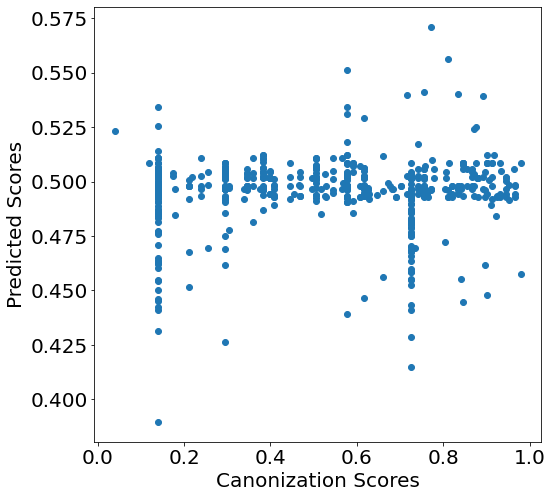

eng xgboost book ['average_sentence_embedding'] rfe full 0.0634631183563171 0.22251142711639554 0.06973216035532652 0.26328686057624007 0.2341586861873171 -0.04637011071804005
chunk
Data included: full
Dropped 768 columns.
Current shape of feature matrix: (12347, 121)
121 4 0.03 0.33 6 0.9206
Current best max_depth: 4
Current best learning_rate: 0.03
Current best colsample_bytree: 0.33
Current best min_child_weight: 6.0
Current best num_boost_round: 374
Current best validation r2 score is 0.9206
############################
Current shape of feature matrix: (12347, 71)
71 4 0.03 0.33 6 0.9114
Current best max_depth: 4
Current best learning_rate: 0.03
Current best colsample_bytree: 0.33
Current best min_child_weight: 6.0
Current best num_boost_round: 470
Current best validation r2 score is 0.9114
############################
Current shape of feature matrix: (12347, 50)
50 4 0.03 0.33 6 0.8926
Current best max_depth: 4
Current best learning_rate: 0.03
Current best colsample_bytree: 0.33
C

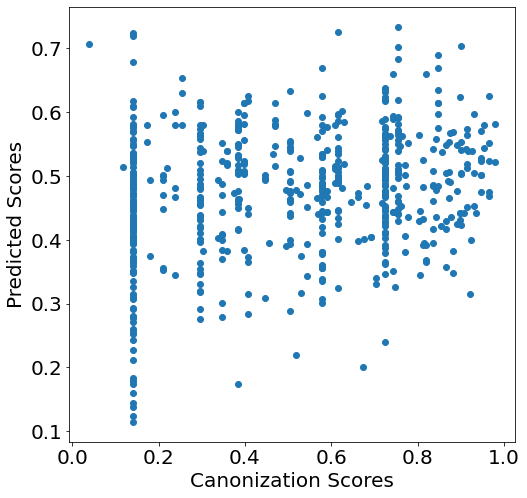

eng xgboost chunk ['average_sentence_embedding'] rfe full 0.026835451541203037 0.1358178763906251 0.06790498416475337 0.25938412774606656 0.22521903530608708 -0.03564473626182933
book_and_averaged_chunk
Data included: full
Dropped 768 columns.
Current shape of feature matrix: (485, 1031)
1031 4 0.03 0.33 6 0.0034
Current best max_depth: 4
Current best learning_rate: 0.03
Current best colsample_bytree: 0.33
Current best min_child_weight: 6.0
Current best num_boost_round: 12
Current best validation r2 score is 0.0034
############################
Current shape of feature matrix: (485, 981)
981 4 0.03 0.33 6 0.063
Current best max_depth: 4
Current best learning_rate: 0.03
Current best colsample_bytree: 0.33
Current best min_child_weight: 6.0
Current best num_boost_round: 72
Current best validation r2 score is 0.063
############################
Current shape of feature matrix: (485, 931)
931 4 0.03 0.33 6 0.0094
Current best max_depth: 4
Current best learning_rate: 0.03
Current best colsamp

781 4 0.03 0.33 6 -0.1079
Current best max_depth: 4
Current best learning_rate: 0.03
Current best colsample_bytree: 0.33
Current best min_child_weight: 6.0
Current best num_boost_round: 3
Current best validation r2 score is -0.1079
############################
Current shape of feature matrix: (481, 731)
731 4 0.03 0.33 6 -0.0561
Current best max_depth: 4
Current best learning_rate: 0.03
Current best colsample_bytree: 0.33
Current best min_child_weight: 6.0
Current best num_boost_round: 5
Current best validation r2 score is -0.0561
############################
Current shape of feature matrix: (481, 681)
681 4 0.03 0.33 6 -0.1259
Current best max_depth: 4
Current best learning_rate: 0.03
Current best colsample_bytree: 0.33
Current best min_child_weight: 6.0
Current best num_boost_round: 1
Current best validation r2 score is -0.1259
############################
Current shape of feature matrix: (481, 631)
631 4 0.03 0.33 6 -0.0543
Current best max_depth: 4
Current best learning_rate: 0.03


KeyboardInterrupt: 

In [6]:
results = []

eng_params = {"features": ["book_and_averaged_chunk"]}
ger_params = {"features": ["chunk"]}

for lang in ["eng", "ger"]: 
    print("Language", lang)
    if lang == "eng":
        param_dir = eng_params
    else:
        param_dir = ger_params
        
    book_df = pd.read_csv(f"{extracted_features_dir}/{lang}/book_df.csv")
    book_and_averaged_chunk_df = pd.read_csv(f"{extracted_features_dir}/{lang}/book_and_averaged_chunk_df.csv")
    chunk_df = pd.read_csv(f"{extracted_features_dir}/{lang}/chunk_df.csv")
    chunk_and_copied_book_df = pd.read_csv(f"{extracted_features_dir}/{lang}/chunk_and_copied_book_df.csv")

    for model in ["xgboost"]:
        for features in ["book", "chunk", "book_and_averaged_chunk", "chunk_and_copied_book"]: #param_dir["features"]: #
            print(features)
            for drop_columns_including in [["average_sentence_embedding"]]:
                for dimensionality_reduction in ["rfe"]:
                    # train and test with either full dataset or only extreme cases
                    for include_data in ["full"]: #, "train_full_test_reduced", "train_reduced_test_reduced"]:
                        print('Data included:', include_data)
                        try:
                            experiment = Experiment(
                                features=features,
                                drop_columns_including=drop_columns_including,
                                dimensionality_reduction=dimensionality_reduction,
                                include_data=include_data,
                                model=model,
                                verbose=True
                            )
                            mean_train_mse, mean_train_mae, mean_validation_mse, mean_validation_rmse, mean_validation_mae, mean_validation_r2 = experiment.run()
                            results.append((lang, model, features, drop_columns_including, dimensionality_reduction, include_data, mean_train_mse, mean_train_mae, mean_validation_mse, mean_validation_rmse, mean_validation_mae, mean_validation_r2))
                            print(lang, model, features, drop_columns_including, dimensionality_reduction, include_data, mean_train_mse, mean_train_mae, mean_validation_mse, mean_validation_rmse, mean_validation_mae, mean_validation_r2)
                        except Exception as e:
                            print(f"Error in {lang}, {model}, {features}, {drop_columns_including}, {dimensionality_reduction}, {include_data}")
                            print(e)
                            raise e